# Generative Adversarial Networks using TensorFlow and the MNIST Dataset

In [1]:
import numpy as np
import sys
import tensorflow as tf
import time

import load_mnist

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm

FLOAT = tf.float32

## Some Utility Functions

In [2]:
def Weight(shape, sd=0.02):
    initial = tf.random_normal(shape, mean=0, stddev=sd)
    return tf.Variable(initial, name="weights")

def Bias(shape, sd=0.02):
    initial = tf.random_normal(shape, mean=0, stddev=sd)
    return tf.Variable(initial, name="bias")

def StridedConv(x, W):
    return tf.nn.conv2d(
        x, W,
        strides=[1, 2, 2, 1],
        padding="SAME", name="strided_conv")

# The function tf.nn.deconv2d is an undecumented part of the TensorFlow API,
# and is pretty half baked. For instance, unlike just about every other similar
# function, deconv2d can't handle a batch size of -1. Even worse, instead of
# throwing a py Exception, it results in an uncaught C++ error that crashes the
# iPython kernel. And its signature or internals may unexpectedly change at any
# point in the future, since it's not a stable part of the API.
#
# Anyway, the crux of the matter is: it forces us to commit to a single batch
# size for the entire network architecture.

BATCH_SIZE = 100

def FractionallyStridedConv(x, W, output_channels=None, batch_size=BATCH_SIZE):
    _, height, width, kernels = x.get_shape().as_list()
    if output_channels is None:
        output_channels = kernels / 2
    return tf.nn.deconv2d(
        x, W,
        [batch_size, height * 2, width * 2, output_channels],
        [1, 2, 2, 1],
        name="fractionally_strided_conv")

# A batch norm that doesn't require running separate update ops!
# Stolen from http://stackoverflow.com/a/34634291
def BatchNorm(should_train, inp, scope="BatchNorm", affine=True):
    with tf.variable_scope(scope):
        beta = tf.Variable(
            tf.constant(0.0, shape=inp.get_shape()[-1:]),
            name="beta", trainable="true")
        gamma = tf.Variable(
            tf.constant(1.0, shape=inp.get_shape()[-1:]),
            name="gamma", trainable="true")
        batch_mean, batch_var = tf.nn.moments(inp, [0, 1, 2], name="moments")
        ema = tf.train.ExponentialMovingAverage(decay=0.9)
        ema_apply_op = ema.apply([batch_mean, batch_var])
        ema_mean = ema.average(batch_mean)
        ema_var = ema.average(batch_var)
        
        def MeanVarWithUpdate():
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)
            
        mean, var = tf.python.control_flow_ops.cond(
            should_train,
            MeanVarWithUpdate,
            lambda: (ema_mean, ema_var))

        return tf.nn.batch_norm_with_global_normalization(
            inp, mean, var, beta, gamma, 0.001, affine)

def LeakyReLUMaker(leak):
    def LeakyReLU(x):
        return tf.maximum(x, 0) + leak * tf.minimum(x, 0)
    return LeakyReLU

def ELU(x):
    pos = tf.cast(tf.greater_equal(x, 0), FLOAT)
    return (pos * x) + ((1 - pos) * (tf.exp(x) - 1))

## Generative Adversarial Networks
See Goodfellow et al (http://arxiv.org/pdf/1406.2661v1.pdf) for a description of GANs.

In essence, we pit two network against each other in a game. A discriminative network attempts to determine whether an input image belongs to the training distribution, or is a forgery. A generative network attempts to produce forgeries which fool the discriminative network.

See Radford, Metz, & Chintala (http://arxiv.org/pdf/1511.06434v1.pdf) for useful constraints on GAN architecture. The authors make the following recommendations:

- Use strided convolutions rather than max pooling.
- Use batchnorm everywhere other than generator output and discriminator input.
- No dense hidden layers.
- ReLU units in the generator (except output, which uses Tanh) and Leaky ReLU (with a leak of 0.2) in the discriminator.

I'll be using exponential liniar units (ELU) instead of ReLU / Leaky ReLU, and see if I can get away without batchnorm, as the ELU addresses some of the same issues: namely, encouraging inputs to each unit to approach 0, and allowing gradients to penetrate further into deep networks. Otherwise, I'll attempt to cleave to their suggestions.

The general architecture that Radford et al recommend for the generator is based on DCGAN. A vector of uniformly distributed noise is projected onto a small 2d image with a large number of channels. Repeated "fractionally strided convolutions" (sometimes erroneously called "deconvolutions", really the transpose of the convolution) successfively scale down the number of channels and scale up the size of the image.

They further recommend the following hyperparameters:
- Weights initialized with a 0-centered normal distribution having a std of 0.02
- Adam optimizer with a learning rate of 0.0002 and beta-1 of 0.5

In [3]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

should_train = tf.placeholder(tf.bool, shape=[])

no existing session to delete


#### Generative Network
The generative network maps a vector of uniform random noise inputs to a 28 x 28 1-channel image via a stack of three fractionally strided convolutional layers.

In [4]:
# G_nonlin = tf.nn.relu
G_nonlin = ELU

# Input a stack of 100-dimensional noise vectors.
# This spans the underlying object space of 10 digits.
G_x = tf.placeholder(FLOAT, [None, 100])

# Project noise into a 4x4 image with many channels.
# We won't update the weight that controls the projection during training.
with tf.name_scope("G_projection") as scope:
    G_W_proj = Weight([100, 4 * 4 * 256])
    G_b_proj = Bias([4 * 4 * 256])
    G_h_proj = tf.reshape(tf.matmul(G_x, G_W_proj) + G_b_proj, [-1, 4, 4, 256])

# Apply fractionally strided convolutions to decrease number of channels and increase image size.
with tf.name_scope("G_fsc1") as scope:
    G_W_fsc1 = Weight([2, 2, 128, 256])
    G_b_fsc1 = Bias([128])
    #G_h_fsc1 = G_nonlin(FractionallyStridedConv(G_h_proj, G_W_fsc1) + G_b_fsc1)
    G_h_fsc1 = G_nonlin(BatchNorm(should_train, FractionallyStridedConv(G_h_proj, G_W_fsc1) + G_b_fsc1))

with tf.name_scope("G_fsc2") as scope:
    G_W_fsc2 = Weight([2, 2, 64, 128])
    G_b_fsc2 = Bias([64])
    #G_h_fsc2 = G_nonlin(FractionallyStridedConv(G_h_fsc1, G_W_fsc2) + G_b_fsc2)
    G_h_fsc2 = G_nonlin(BatchNorm(should_train, FractionallyStridedConv(G_h_fsc1, G_W_fsc2) + G_b_fsc2))

with tf.name_scope("G_fsc3") as scope:
    G_W_fsc3 = Weight([2, 2, 1, 64])
    G_b_fsc3 = Bias([1])
    G_h_fsc3 = tf.nn.tanh(FractionallyStridedConv(G_h_fsc2, G_W_fsc3, output_channels=1) + G_b_fsc3)

# Trim output to 28x28 and put in the same scale as the source image
with tf.name_scope("G_out") as scope:
    G_y = tf.slice(G_h_fsc3, [0, 2, 2, 0], [-1, 28, 28, -1])
    G_image = tf.reshape((G_y + 1) * 127.5, [-1, 28, 28])

#### Discriminative Network

The discriminative network maps a 28 x 28 1-channel image to single float between 0 and 1, representing the probability that the image came from the training data distribution rather than the generative network.

The input of the discriminator is hooked up to the output of the generator. This lets us either train the discriminator, by ignoring the generator portion of the computation graph and providing input images in the feed dict, or the generator, by freezing the variables in the discriminator and feeding in noise.

In [5]:
# D_nonlin = LeakyReLUMaker(0.2)
D_nonlin = ELU

# Input is a stack of 28 x 28 black and white images with activations from 0 to 255.
D_x = G_y

# Target vector is a 1 (real) or 0 (forgery) for each input.
D_y_ = tf.placeholder(FLOAT, [None])

# Stack strided convolutional layers.
# Input should be 32x32, output 16x16
PADDING = [[0, 0], [2, 2], [2, 2], [0, 0]]
with tf.name_scope("D_sc1") as scope:
    D_W_conv1 = Weight([3, 3, 1, 16])
    D_b_conv1 = Bias([16])
    #D_h_conv1 = D_nonlin(StridedConv(tf.pad(D_x, PADDING), D_W_conv1) + D_b_conv1)
    D_h_conv1 = D_nonlin(BatchNorm(should_train, StridedConv(tf.pad(D_x, PADDING), D_W_conv1) + D_b_conv1))

# Input should be 16x16, output 8x8
with tf.name_scope("D_sc2") as scope:
    D_W_conv2 = Weight([3, 3, 16, 32])
    D_b_conv2 = Bias([32])
    #D_h_conv2 = D_nonlin(StridedConv(D_h_conv1, D_W_conv2) + D_b_conv2)
    D_h_conv2 = D_nonlin(BatchNorm(should_train, StridedConv(D_h_conv1, D_W_conv2) + D_b_conv2))

# Input should be 8x8, output 4x4
with tf.name_scope("D_sc3") as scope:
    D_W_conv3 = Weight([3, 3, 32, 64])
    D_b_conv3 = Bias([64])
    #D_h_conv3 = D_nonlin(StridedConv(D_h_conv2, D_W_conv3) + D_b_conv3)
    D_h_conv3 = D_nonlin(BatchNorm(should_train, StridedConv(D_h_conv2, D_W_conv3) + D_b_conv3))

# Output a single float between 0 and 1
with tf.name_scope("D_output") as scope:
    D_h_flat = tf.reshape(D_h_conv3, [-1, 4 * 4 * 64])
    D_W_out = Weight([4 * 4 * 64, 1])
    D_b_out = Bias([1])
    D_y = tf.nn.sigmoid(tf.matmul(D_h_flat, D_W_out) + D_b_out)

#### Adversarial Training

In [6]:
# Generator
# When we evaluate the generator training step, we feed noise into G_x.
# Never evaluate the generator train step when feeding real images into D_x.
# The outputs of D_y represent probability that the discriminator thinks
# generated images are real. So, we want to maximize some monotonically increasing
# function of D_y, ie minimize a monotonically decreasing function of D_y.

G_trainable_vars = [
    G_W_fsc1, G_b_fsc1,
    G_W_fsc2, G_b_fsc2,
    G_W_fsc3, G_b_fsc3]
G_err = -tf.reduce_mean(tf.log(D_y))
G_train_step = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(
    G_err,
    var_list=G_trainable_vars)

# Discriminator
# When we evauate the descriminator train step, each minibatch should contain
# a mix of real and forged images, randomly shuffled, to prevent oscillation.
# We use cross entropy as our error metric.

D_trainable_vars = [
    D_W_conv1, D_b_conv1,
    D_W_conv2, D_b_conv2,
    D_W_conv3, D_b_conv3,
    D_W_out, D_b_out]
D_xent = -tf.reduce_mean(D_y_ * tf.log(D_y)) - tf.reduce_mean((1 - D_y_) * tf.log(1 - D_y))
D_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.greater_equal(D_y, 0.5), FLOAT), D_y_), FLOAT))
D_train_step = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(
    D_xent,
    var_list=D_trainable_vars)

#### TensorBoard Annotations

In [7]:
hist_summaries = [
    tf.histogram_summary(var._variable.name, var)
    for var in G_trainable_vars + D_trainable_vars]

scalar_summaries = [
    tf.scalar_summary(name, var)
    for var, name in zip(
        (G_err, D_xent, D_accuracy),
        ("Generator Error", "Discriminator Cross-Entropy", "Discriminator Accuracy"))]

G_image_summary = tf.image_summary("Generator Output", G_y, max_images=10)

all_summaries = tf.merge_all_summaries()
writer = tf.train.SummaryWriter("/tmp/mnist_logs", sess.graph_def)

#### Fetch and read in data

In [8]:
try:
    (train_im, test_im, train_labels, test_labels)
except:
    train_im, test_im, train_labels, test_labels = load_mnist.Datasets()

#### Initialie vars

In [12]:
sess.run(tf.initialize_all_variables())

#### Main loop
For each minibatch:
1. Generate forgeries.
2. Train the discriminator on a mix of forgeries and real images.
3. Train the generator.

I've tried this with random normals, random uniforms from 0 to 1, and random uniforms from -1 to 1 as the input Z vectors. For some reason, for all but random uniforms -1 to 1, the generator produces nearly identical outputs for all inputs, and the network oscillates during training. In fact, training failed so completey that I thought I'd made a typo in the error function.

I'm stumped as for an explanation. Why is the shape and center of the noise distribution so important?

TODO: Look into it!

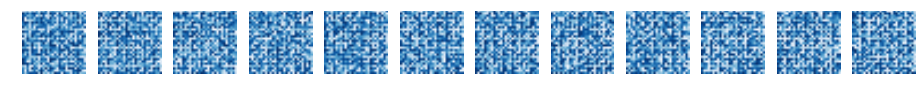

....................
Epoch 0, batch 19 (21.8 seconds since last report)
DISCRIMINATOR: real 87% / 0.57693, forged 33% / 0.70941
GENERATOR: error = 0.68
[0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
....................
Epoch 0, batch 39 (19.8 seconds since last report)
DISCRIMINATOR: real 63% / 0.66988, forged 4% / 0.74473
GENERATOR: error = 0.64
[0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
...

KeyboardInterrupt: 

In [13]:
num_epochs = 100
batch_size = BATCH_SIZE
half_batch = batch_size / 2
disc_targets = np.concatenate((np.zeros(half_batch), np.ones(half_batch)))
validate_batch_size = BATCH_SIZE
validate_every_n_batches = 20
use_tensorboard = False

figsize(16, 1.5)

def Noise(*size):
    return np.random.uniform(-1, 1, size=size)

def PrepBatch(ims, start, stop):
    batch = ims[start:stop].reshape((stop - start,) + ims.shape[1:3] + (1,))
    return (batch / 127.5) - 1

batches_per_epoch = train_im.shape[0] / batch_size
mark = time.time()
train_gen = True
train_disc = True
reference_noise = Noise(batch_size, 100)
for ep in xrange(num_epochs):
    
    # Print generator outputs for reference noise vectors
    forgeries = G_image.eval(feed_dict={
        G_x: reference_noise,
        should_train: False})
    _, axes = plt.subplots(1, 12)
    for ax in xrange(12):
        axes[ax].axis("off")
        axes[ax].imshow(forgeries[ax], cmap=cm.Blues)
    plt.show()
    
    # Reorder the training set
    np.random.shuffle(train_im)

    for i in xrange(batches_per_epoch):
        sys.stdout.write(".")
        sys.stdout.flush()
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        batch_indices = np.arange(BATCH_SIZE)
        np.random.shuffle(batch_indices)

        # Train the discriminator
        forgeries = G_y.eval(feed_dict={
            G_x: Noise(batch_size, 100),
            should_train: False})
        real = PrepBatch(train_im, start_offset, stop_offset)
        for j in xrange(2):
            half_start = j * half_batch
            half_stop = half_start + half_batch
            train_data = np.concatenate((
                forgeries[half_start:half_stop],
                real[half_start:half_stop]))
            D_train_step.run(feed_dict={
                D_x: train_data[batch_indices],
                D_y_: disc_targets[batch_indices],
                should_train: True})

        # Train the generator
        G_train_step.run(feed_dict={
            G_x: Noise(batch_size, 100),
            should_train: True})

        # Validation
        if (i + 1) % validate_every_n_batches == 0:
            
            # With Tensorboard, validate more often but print less.
            if use_tensorboard:
                forgeries = G_y.eval(feed_dict={
                    G_x: Noise(batch_size, 100),
                    should_train: False})
                real = PrepBatch(test_im, 0, half_batch)
                test_data = np.concatenate((forgeries[0:half_batch], real))
                summary_str, acc = sess.run(
                    [all_summaries, D_accuracy],
                    feed_dict={
                        D_x: test_data,
                        D_y_: disc_targets,
                        should_train: False})
                writer.add_summary(
                    summary_str,
                    i + (batches_per_epoch * ep))
                print "Epoch {ep}, batch {ba}: accuracy = {ac}".format(
                    ep=ep, ba=i, ac=acc)

            # Without Tensorboard, validate less often but print more.
            else:
                ac_real, xent_real = sess.run(
                    [D_accuracy, D_xent], feed_dict={
                        D_x: PrepBatch(test_im, 0, validate_batch_size),
                        D_y_: np.ones(validate_batch_size),
                        should_train: False})
                
                gammas = [v for v in tf.all_variables() if v.name.endswith("gamma:0")]
                betas = [v for v in tf.all_variables() if v.name.endswith("beta:0")]
                results = sess.run(
                    [D_accuracy, D_xent, G_err] + betas + gammas,
                    feed_dict={
                        G_x: Noise(validate_batch_size, 100),
                        D_y_: np.zeros(validate_batch_size),
                        should_train: False})
                ac_forged, xent_forged, ger = results[:3]
                betavals = results[3:8]
                gamavals = results[8:]
                print ("\nEpoch {ep}, batch {ba} ({t:.1f} seconds since last report)"
                       "\nDISCRIMINATOR: real {acr:.0f}% / {xr:.5f}, "
                       "forged {acf:.0f}% / {xf:.5f}"
                       "\nGENERATOR: error = {ger:.2f}").format(
                    ep=ep, ba=i, t=time.time() - mark,
                    acr=ac_real * 100, xr=xent_real, acf=ac_forged * 100, xf=xent_forged, ger=ger)
                print [np.mean(b) for b in betavals]
                print [np.mean(g) for g in gamavals]
                mark = time.time()

In [14]:
[v.name for v in tf.all_variables()]

[u'G_projection/weights:0',
 u'G_projection/bias:0',
 u'G_fsc1/weights:0',
 u'G_fsc1/bias:0',
 u'G_fsc1/BatchNorm/beta:0',
 u'G_fsc1/BatchNorm/gamma:0',
 u'G_fsc1/BatchNorm/G_fsc1/BatchNorm/moments/mean/ExponentialMovingAverage:0',
 u'G_fsc1/BatchNorm/G_fsc1/BatchNorm/moments/variance/ExponentialMovingAverage:0',
 u'G_fsc2/weights:0',
 u'G_fsc2/bias:0',
 u'G_fsc2/BatchNorm/beta:0',
 u'G_fsc2/BatchNorm/gamma:0',
 u'G_fsc2/BatchNorm/G_fsc2/BatchNorm/moments/mean/ExponentialMovingAverage:0',
 u'G_fsc2/BatchNorm/G_fsc2/BatchNorm/moments/variance/ExponentialMovingAverage:0',
 u'G_fsc3/weights:0',
 u'G_fsc3/bias:0',
 u'D_sc1/weights:0',
 u'D_sc1/bias:0',
 u'D_sc1/BatchNorm/beta:0',
 u'D_sc1/BatchNorm/gamma:0',
 u'D_sc1/BatchNorm/D_sc1/BatchNorm/moments/mean/ExponentialMovingAverage:0',
 u'D_sc1/BatchNorm/D_sc1/BatchNorm/moments/variance/ExponentialMovingAverage:0',
 u'D_sc2/weights:0',
 u'D_sc2/bias:0',
 u'D_sc2/BatchNorm/beta:0',
 u'D_sc2/BatchNorm/gamma:0',
 u'D_sc2/BatchNorm/D_sc2/BatchNo